In [1]:
%run flow_tools.py

In [2]:
df2 = pd.concat([pd.read_csv('snipr_linkers.csv', index_col=0),
                pd.read_csv('notch_linkers.csv', index_col=0)],
               names=['Receptor','Index'],keys=['SNIPR','SynNotch']).reset_index()

/opt/homebrew/Caskroom/miniforge/base/envs/flow/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
filters = ((df2['logFITC-A'] > 5))
dist = df2[filters]['logDAPI-A'].values[:,np.newaxis]
model = GaussianMixture(2, covariance_type='spherical', random_state=237).fit(dist)
off_component = np.argmin(model.means_)
df_summary = (df2[filters]
              .groupby(['Sender','Receiver','Receptor','Replicate'])['logDAPI-A']
              .apply(lambda x: 100*(1-np.sum(model.predict(x.values[:,np.newaxis])==off_component)/len(x)))
              .reset_index())

In [4]:
df_summary.Receiver.unique()

array(['LCB1(L)-Notch', 'LCB1(R)-Notch', 'LCB1(S)-Notch', 'LCB1-Notch',
       'No Notch'], dtype=object)

In [5]:
df_summary = df_summary.replace(to_replace='-Notch', value='', regex=True)
df_summary = df_summary.replace(to_replace='LCB1', value='LCB1-Simple')
df_summary = df_summary.replace(to_replace='LCB1(S)', value='LCB1-Short')
df_summary = df_summary.replace(to_replace='LCB1(L)', value='LCB1-Long')
df_summary = df_summary.replace(to_replace='LCB1(R)', value='LCB1-Rigid')

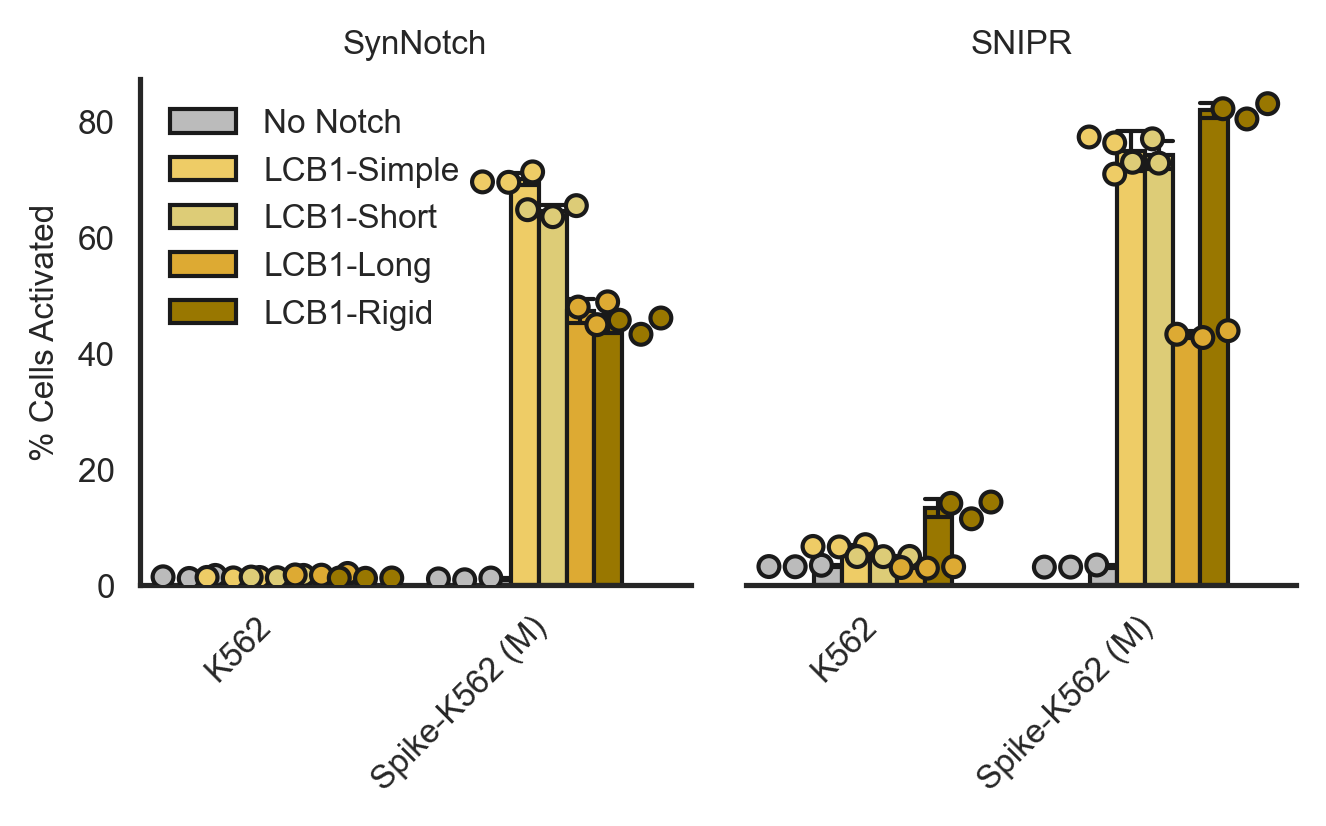

In [6]:
effectors = ['No Notch','LCB1-Simple','LCB1-Short','LCB1-Long', 'LCB1-Rigid']
targets = ['K562', 'Spike-K562 (M)']
colors = [grey, light_yellow, '#DDCC77', '#DDAA33', dark_yellow]
g = sns.catplot(data=df_summary, col='Receptor', x='Sender',y='logDAPI-A',hue='Receiver', kind='swarm',
                col_order=['SynNotch','SNIPR'], order=targets, hue_order=effectors, 
                edgecolor='k', linewidth=1, dodge=True, palette=colors)
g.map_dataframe(sns.barplot, x='Sender', y='logDAPI-A', order=targets,
                hue_order=effectors, errorbar='sd', hue='Receiver',palette=colors,
                dodge=True, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean',
                err_kws={'linewidth': 1, 'color':'k'}, legend=True)
g.figure.set_size_inches(4.6,2)
g.figure.set_dpi(300)
g.set_xlabels('')
g.set_xticklabels(rotation=45, ha='right', size=SMALL_SIZE)
g.fig.subplots_adjust(wspace=0.1)
g.set_titles(col_template='{col_name}', size=SMALL_SIZE)
g.legend.remove()
handles, labels = g.axes.flat[1].get_legend_handles_labels()
order = [5,6,7,8,9]
g.axes.flat[0].legend([handles[idx] for idx in order],
           [labels[idx] for idx in order],
           frameon=False, loc='upper left')
for ax in g.axes.flat[1:]:
    ax.spines[['left']].set_visible(False)
g.set_ylabels('% Cells Activated', size=SMALL_SIZE)
plt.savefig(outputdir+'sn_linker_comparison.pdf', bbox_inches='tight')

In [7]:
expression_df = (df2[(df2['Sender']=='None')]
                 .groupby(['Receiver','Receptor','Replicate'])['APC-A']
                 .median()
                 .reset_index())
expression_df = expression_df.replace(to_replace='-Notch', value='', regex=True)
expression_df = expression_df.replace(to_replace='LCB1', value='LCB1-Simple')
expression_df = expression_df.replace(to_replace='LCB1(S)', value='LCB1-Short')
expression_df = expression_df.replace(to_replace='LCB1(L)', value='LCB1-Long')
expression_df = expression_df.replace(to_replace='LCB1(R)', value='LCB1-Rigid')

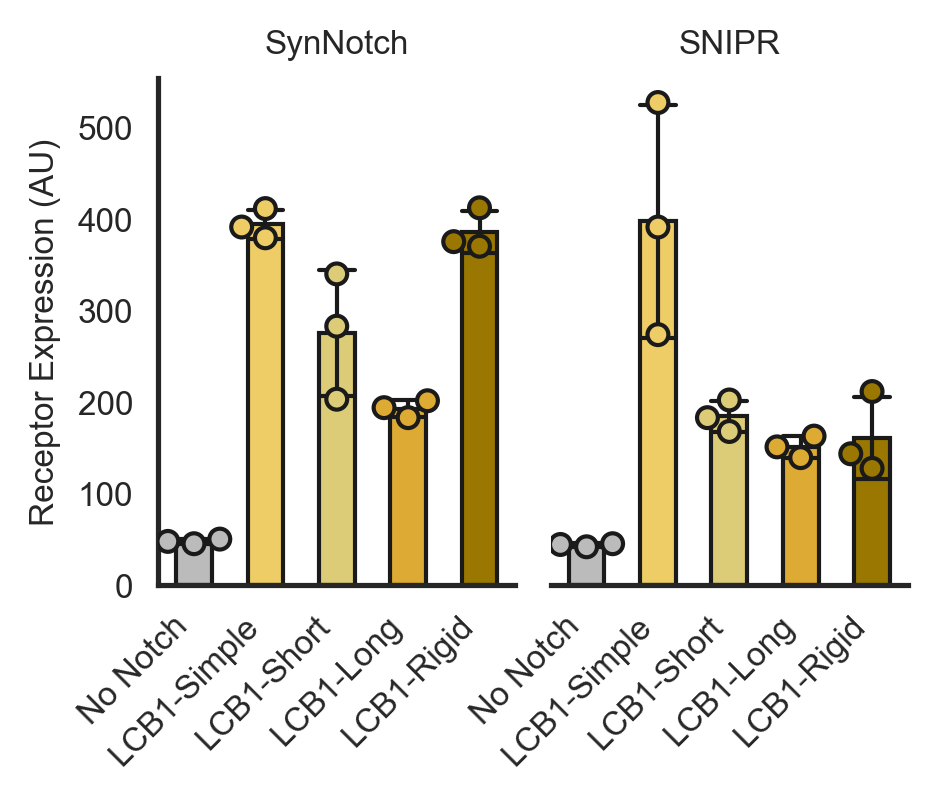

In [8]:
effectors = ['No Notch','LCB1-Simple','LCB1-Short','LCB1-Long', 'LCB1-Rigid']
colors = [grey, light_yellow, '#DDCC77', '#DDAA33', dark_yellow]
g = sns.catplot(data=expression_df, col='Receptor', x='Receiver',y='APC-A',hue='Receiver', kind='swarm',
                col_order=['SynNotch','SNIPR'], order=effectors, hue_order=effectors, 
                edgecolor='k', linewidth=1, dodge=False, palette=colors)
g.map_dataframe(sns.barplot, x='Receiver', y='APC-A', order=effectors,
                hue_order=effectors, errorbar='sd', hue='Receiver',palette=colors,
                dodge=False, edgecolor='k', capsize=0.5, width=0.5, saturation=1,
                estimator='mean',
                err_kws={'linewidth': 1, 'color':'k'}, legend=True)
g.figure.set_size_inches(3,2)
g.figure.set_dpi(300)
g.set_xlabels('')
g.set_xticklabels(rotation=45, ha='right', size=SMALL_SIZE)
g.fig.subplots_adjust(wspace=0.1)
g.set_titles(col_template='{col_name}', size=SMALL_SIZE)
g.legend.remove()
for ax in g.axes.flat[1:]:
    ax.spines[['left']].set_visible(False)
g.set_ylabels('Receptor Expression (AU)', size=SMALL_SIZE)
plt.savefig(outputdir+'sn_linker_expression.pdf', bbox_inches='tight')